# Creation of New CSV with Languages & no Duplicates

In [1]:
# !pip install -U git+https://github.com/aboSamoor/polyglot.git@master
# create track language column, done
# df = pd.read_csv('https://raw.githubusercontent.com/aguilargallardo/DS-Unit-2-Applied-Modeling/master/data/SpotifyFeatures.csv')
# df = df.dropna()
# raw_df = raw_df.drop_duplicates(subset='track_name')
# raw_df.shape
# raw_df.to_csv('spotify_unique_track_id.csv', index=False)
# df.shape

# df.to_csv('spotify_unique_track_id.csv', index=False)
# Data already has duplicate track names and nulls removed.
# from polyglot.text import Text,Word
# def get_language(track_name):
#     try:
#         return(Text(track_name).language.name)
#     except: 
#         return("Unknown")

# df.track_name = df.track_name.astype(str)
# df['track_lang'] = df.track_name.apply(get_language)

# df.to_csv('spotify_unique_track_id_lang.csv', index=False)

# Imports and Installs

In [2]:
import pandas as pd
import numpy as np 
#import pandas_profiling 
from sklearn import preprocessing # for category encoder
# from polyglot.detect import Detector # for language detection stretch
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
# much more efficient for larger files like Nearest Neighbors which the model
import joblib
import plotly.express as px
import plotly.graph_objects as go

# EDA & PROFILE REPORT

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Build-Week-Spotify-Song-Suggester-5/Data-Science/master/spotify_unique_track_id_lang.csv')
# drop duplicates
df = df.drop_duplicates(subset=['track_name', 'artist_name'])
df.shape

(176514, 19)

In [4]:
# re-order track_lang from the end to after track_name
df = df [['genre', 'artist_name', 'track_name', 'track_lang', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']]

In [5]:
# they can only fit 75k on the Heroku
df = df.sort_values('popularity', ascending=False)[:75000]
df.shape

(75000, 19)

In [6]:
groupby_genre = df.groupby(['genre'])

In [7]:
groupby_genre_df = groupby_genre.mean()

In [8]:
groupby_genre_df

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
genre,,,,,,,,,,,
A Capella,44.000000,0.780000,0.616000,223813.000000,0.298000,0.000000,0.097300,-7.712000,0.027400,82.471000,0.712000
Alternative,51.010425,0.161173,0.541951,232926.228773,0.712842,0.059728,0.195053,-6.504939,0.089642,122.337206,0.449112
Anime,46.396491,0.147176,0.489208,257335.910526,0.788534,0.085538,0.209409,-5.110679,0.071969,131.315028,0.490506
Blues,47.177282,0.339468,0.528848,242445.472095,0.590056,0.080638,0.202259,-9.216211,0.057959,120.279586,0.576147
Children's Music,44.000000,0.474848,0.694619,156495.666667,0.423429,0.085929,0.168976,-11.277571,0.059943,113.821667,0.730762
Children’s Music,53.385246,0.141759,0.525109,234215.719672,0.723688,0.027107,0.194981,-6.205175,0.069706,123.263584,0.442311
Classical,46.650876,0.792981,0.312098,298194.858533,0.229438,0.617128,0.141478,-20.931949,0.049424,105.483016,0.209754
Comedy,44.353333,0.767230,0.551367,252806.036667,0.790793,0.000059,0.721582,-8.217337,0.800496,101.280577,0.387063
Country,48.519916,0.274868,0.576805,216895.917400,0.635400,0.005886,0.179262,-7.374925,0.047012,123.438678,0.542499


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
dims = (11.7, 8.27)

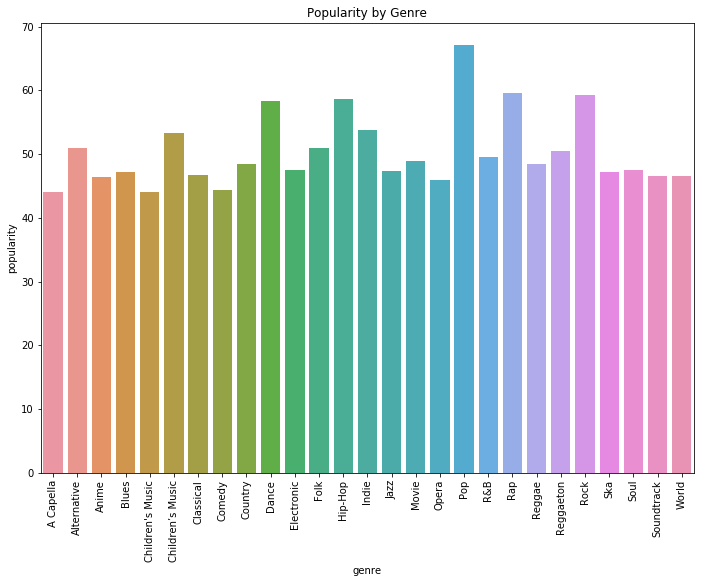

In [10]:
fig, ax = plt.subplots(figsize=dims)
plt.title('Popularity by Genre');
popchart = sns.barplot(x=groupby_genre_df.index, y=groupby_genre_df.popularity);
popchart.set_xticklabels(labels = groupby_genre_df.index, rotation=90);
# save and send to everyone else
f = popchart.get_figure()
f.savefig("popchart.jpg")

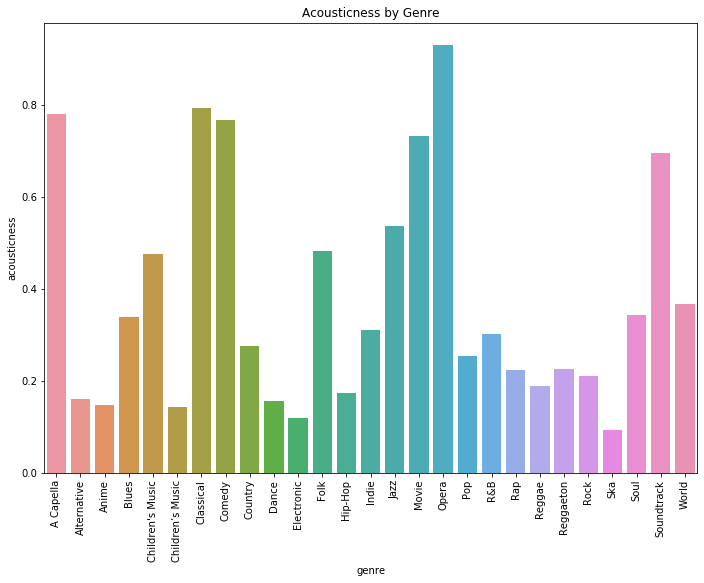

In [11]:
fig, ax = plt.subplots(figsize=dims)
plt.title('Acousticness by Genre');
accoustchart = sns.barplot(x=groupby_genre_df.index, y=groupby_genre_df.acousticness);
accoustchart.set_xticklabels(labels = groupby_genre_df.index, rotation=90);

f = accoustchart.get_figure()
f.savefig("accoustchart.jpg")

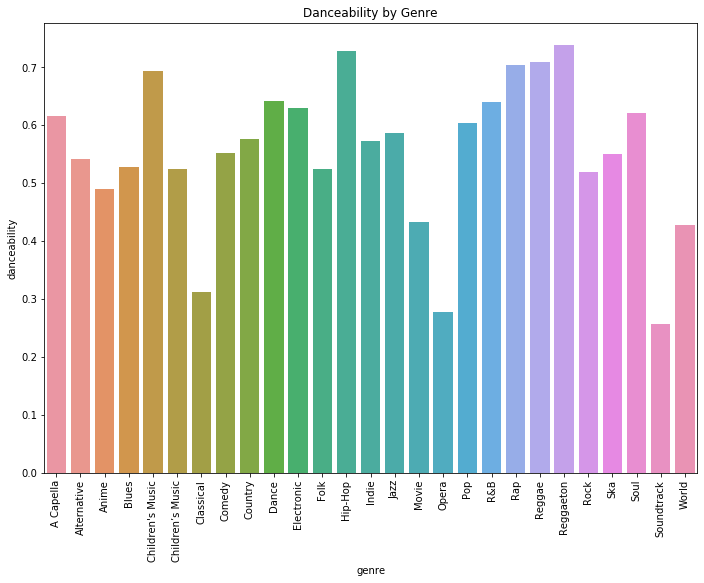

In [12]:
fig, ax = plt.subplots(figsize=dims)
plt.title('Danceability by Genre');
dancechart = sns.barplot(x=groupby_genre_df.index, y=groupby_genre_df.danceability);
dancechart.set_xticklabels(labels = groupby_genre_df.index, rotation=90);


f = dancechart.get_figure()
f.savefig("dancechart.jpg")

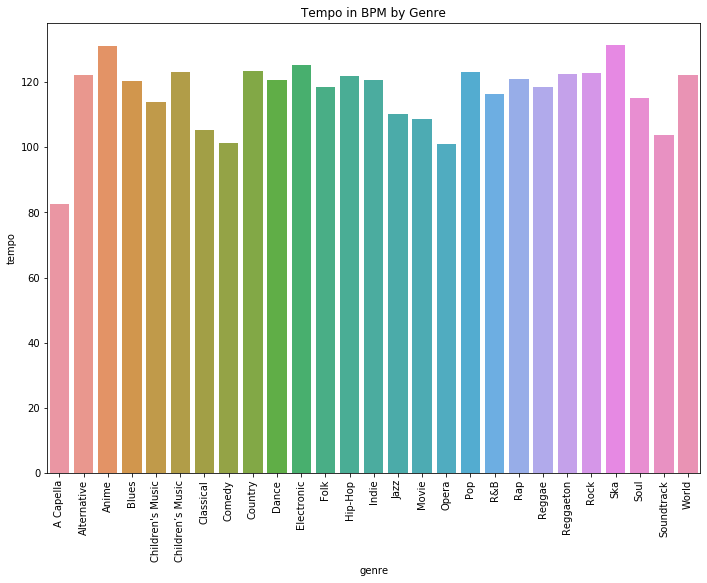

In [13]:
fig, ax = plt.subplots(figsize=dims)
plt.title('Tempo in BPM by Genre');
tempochart = sns.barplot(x=groupby_genre_df.index, y=groupby_genre_df.tempo);
tempochart.set_xticklabels(labels = groupby_genre_df.index, rotation=90);

f = tempochart.get_figure()
f.savefig("tempochart.jpg")

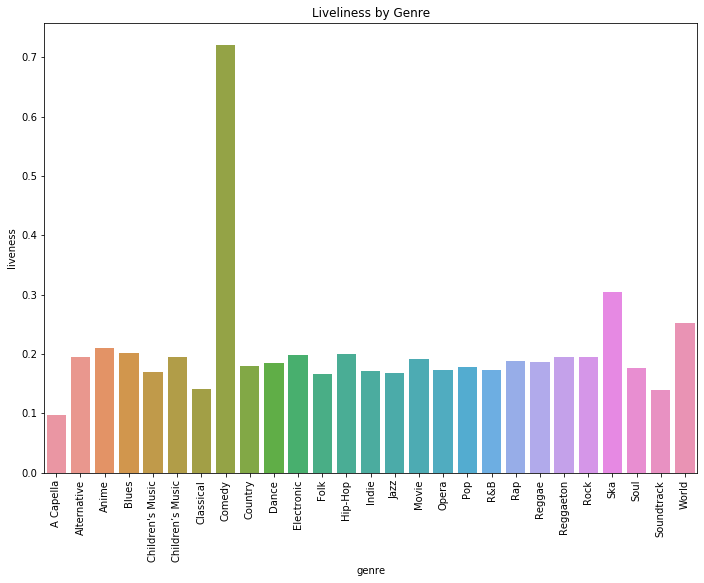

In [14]:
fig, ax = plt.subplots(figsize=dims)
plt.title('Liveliness by Genre');
livechart = sns.barplot(x=groupby_genre_df.index, y=groupby_genre_df.liveness);
livechart.set_xticklabels(labels = groupby_genre_df.index, rotation=90);

f = livechart.get_figure()
f.savefig("livechart.jpg")

# Visualization Stretch Goal Stuff

In [16]:
# def create_web_chart(df):
#     music_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
    
#     fig = go.Figure()

#     for idx, row in df.iterrows():
#         # vals = list(df.iloc[idx][music_features].values)
#         row_df = pd.DataFrame(df.loc[idx][music_features].T).reset_index().rename(columns={idx:'values', 'index':'feature'})
#         fig.add_trace(go.Scatterpolar(
#                                     r=row_df['values'],
#                                     theta=row_df['feature'],
#                                     fill='toself',
#                                     name= f'{row.artist_name} - {row.track_name}'
#                     ))
#     # fig.show()
#     return fig
# fig = create_web_chart(df.iloc[0:5])
# fig.show()


# first_song_values = list(df.iloc[0][music_features].values)
# second_song_values = list(df.iloc[1][music_features].values)
# fig = px.bar(first_song_df, x='feature', y="values", color='feature')
# fig.show()

# fig.add_trace(go.Scatterpolar(
#       r=second_song_df['values'],
#       theta=second_song_df['feature'],
#       fill='toself',
#       name='Second Song'
# ))

# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True,
#       range=[0, 1]
#     )),
#   showlegend=True
# )

# fig.show()

# ENCODING OF FEATURES

NOTE THAT IF YOU RUN THIS CELL AGAIN WITHOUT RESTARTING RUNTIME YOU'LL ENCODE AND BIND ANOTHER COPY OF GENRE ENCODINGS SIGNIFICANTLY INCREASING THE SIZE OF THE FEATURE SET WHILE ADDING NEGATIVE VALUE

In [17]:
# helper function to one hot encode genre
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

time_sig_encoding = { '0/4' : 0, '1/4' : 1, 
                         '3/4' : 3, '4/4' : 4,
                         '5/4' : 5}

key_encoding = { 'A' : 0, 'A#' : 1, 'B' : 2,
                    'C' : 3,  'C#' : 4,  'D' : 5,
                    'D#' : 6, 'E' : 7, 'F' : 8,
                    'F#' : 9, 'G' : 10, 'G#' : 11 }

mode_encoding = { 'Major':0, 'Minor':1}      

df['key'] = df['key'].map(key_encoding)
df['time_signature'] = df['time_signature'].map(time_sig_encoding)
df['mode'] = df['mode'].map(mode_encoding)
df = encode_and_bind(df, 'genre')    

In [18]:
df = encode_and_bind(df, 'track_lang')

In [58]:
# df.genre.value_counts()
df.head(100)

,genre,artist_name,track_name,track_lang,track_id,popularity,acousticness,danceability,duration_ms,energy,...,track_lang_Waray,track_lang_Welsh,track_lang_Western Frisian,track_lang_Wolof,track_lang_Xhosa,track_lang_Yoruba,track_lang_Zhuang,track_lang_Zulu,track_lang_un,track_lang_zzp
9027,Dance,Ariana Grande,7 rings,English,14msK75pk3pA33pzPVNtBF,100,0.5780,0.725,178640,0.321,...,0,0,0,0,0,0,0,0,0,0
86951,Rap,Post Malone,Wow.,English,6MWtB6iiXyIwun0YzU6DFP,99,0.1630,0.833,149520,0.539,...,0,0,0,0,0,0,0,0,0,0
9026,Dance,Ariana Grande,"break up with your girlfriend, i'm bored",English,4kV4N9D1iKVxx1KLvtTpjS,99,0.0421,0.726,190440,0.554,...,0,0,0,0,0,0,0,0,0,0
66643,Hip-Hop,Daddy Yankee,Con Calma,English,5w9c2J52mkdntKOmRLeM2m,98,0.1100,0.737,193227,0.860,...,0,0,0,0,0,0,0,0,0,0
107812,Pop,Marshmello,Happier,English,2dpaYNEQHiRxtZbfNsse99,97,0.1910,0.687,214290,0.792,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87186,Rap,6ix9ine,BEBE (feat. Anuel Aa),Scots,4KkUjFkcQvGvWekl8RATDn,88,0.1720,0.635,217822,0.902,...,0,0,0,0,0,0,0,0,0,0
107935,Pop,Marshmello,FRIENDS,English,08bNPGLD8AhKpnnERrAc6G,88,0.2050,0.626,202621,0.880,...,0,0,0,0,0,0,0,0,0,0
108176,Pop,Kygo,Happy Now,English,14sOS5L36385FJ3OL8hew4,88,0.3740,0.693,211362,0.575,...,0,0,0,0,0,0,0,0,0,0
66634,Hip-Hop,French Montana,No Stylist,English,04MLEeAMuV9IlHEsD8vF6A,88,0.0215,0.765,192172,0.704,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Ari = df['artist_name'] == "Ariana Grande"
# df[Ari].head

In [20]:
df.columns

Index(['genre', 'artist_name', 'track_name', 'track_lang', 'track_id',
       'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       ...
       'track_lang_Waray', 'track_lang_Welsh', 'track_lang_Western Frisian',
       'track_lang_Wolof', 'track_lang_Xhosa', 'track_lang_Yoruba',
       'track_lang_Zhuang', 'track_lang_Zulu', 'track_lang_un',
       'track_lang_zzp'],
      dtype='object', length=162)

# MODELING: Nearest Neighbors
resources: https://scikit-learn.org/stable/modules/neighbors.html

In [21]:
# instantiate model
neigh = NearestNeighbors(n_neighbors=25)
not_features = ['genre', 'artist_name', 'track_name', 'track_lang', 'track_id'] # in case someone wants to change it later
features =[item for item in list(df.columns) if item not in not_features]
X = df[features].values
# y = df[target]
# X.shape 
# y.shape
# target = 'track_id'

%time
neigh.fit(X) # NN doesn't need to fit Y

Wall time: 0 ns


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                 radius=1.0)

# Manual Model Test on 1 Song Example

In [22]:
# random test song

test_song = X[8980]
df.iloc[8980]

distance, neighbors = neigh.kneighbors(np.array([test_song]))
distance, neighbors

song_list = []
for idx in neighbors[0][1:]: # this way excludes itself
    row = df.iloc[idx]
    # print(f'Artist: {row.artist_name} - Track: {row.track_name}')
    song_list.append((row.artist_name, row.track_name))
print(song_list)

[('The Chainsmokers', 'This Feeling - Young Bombs Remix'), ('Nao', 'Get to Know Ya'), ('Bumkey', 'When I Saw You'), ('Bhavi', 'No Lo Entiendo'), ('Tony Bennett', 'One for My Baby (And One More for the Road)'), ('Authority Zero', 'Bayside'), ('Gringo', 'GIGI (ZKITTLEZ)'), ('Dan Auerbach', 'Never in My Wildest Dreams'), ('Mono:Massive', 'Do Some Real'), ('Yashua', 'Pena'), ('Miguel', 'My Piece'), ('IAMDDB', 'Back Again'), ('Nicky Jam', 'Jaleo'), ('Souleance', 'La Californie'), ('Adriel Favela', 'La Escuela No Me Gustó'), ('Billy Raffoul', 'Driver'), ('A$AP Mob', 'Way Hii'), ('Popcaan', 'Superstar'), ('Leven Kali', 'Joy'), ('Chris Stapleton', 'Second One To Know'), ('SoMo', 'I Wish'), ('One Direction', 'Heart Attack'), ('A$AP Mob', 'Bachelor'), ('Sheena Ringo', '急がば回れ')]


# Helper Function to Return 10 Nearest Neighbors

In [23]:
"""
function for what was done manually above
generalized for other dataframes instead of hard coded therefore:
takes in a dataframe, a feature set array, and a song ID
and returns a list of song_id
"""
from typing import List, Tuple
import random 

def closest_ten(df: pd.DataFrame, X_array: np.ndarray ,song_id: int) -> List[Tuple] :
    song = df.iloc[song_id]
    X_song = X[song_id]
    _, neighbors = neigh.kneighbors(np.array([X_song]))
    song_list = []
    for idx in neighbors[0][2:]: 
        row = df.iloc[idx]
       # print(f'Artist: {row.artist_name} - Track: {row.track_name}')
        song_list.append(row.track_id)
    only_10 = random.sample(song_list, 10)
    return(only_10)

In [24]:
# example of function call 
closest_ten(df, X, 9027)

['2hgzdQdnfWwtdpZbhZlV72',
 '3q7CL3dh2u23ZQEwixtAIi',
 '1G576qOKq0CdSGvSmHD4pz',
 '5AuuQOyOLEP9Lnxp0nLvrQ',
 '1qZuf7zgRHKgfSijGm2CTy',
 '3Akw1yw6W6bQ7GXB0FCoe5',
 '5S9o5O3JJ5SzkimwPVaL26',
 '6XEbIRw3DVFb6vQftaewOD',
 '2fRCatGWX9AFqc4VIER4Zu',
 '7hlLPJo0pxh1jQUERqf5O2']

# PCA -> NN

In [25]:
# make copy to transform in case you want to do stuff with the other one later in notebook
df_copy = df[features].copy()

In [26]:
from numpy import array, mean, std, cov
from numpy.linalg import eig
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [27]:
means = df_copy.mean()
# print("\n Means:", means)
scaler = StandardScaler()

In [40]:
pca_X = scaler.fit_transform(df_copy.values)
# pca = PCA(0.95)
pca = PCA(2)
df_pca = pca.fit(pca_X)

In [41]:
print(pca.explained_variance_)

[3.91866083 2.12637133]


In [30]:
%time
pca_neigh = NearestNeighbors(n_neighbors=50)
pca_neigh.fit(pca_X) # NN doesn't need to fit Y

Wall time: 0 ns


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                 radius=1.0)

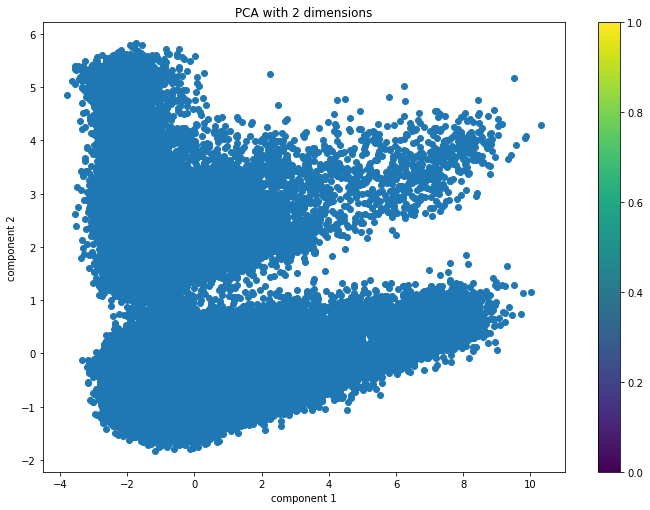

In [86]:
graph_data = pca.fit_transform(pca_X)
fig, ax = plt.subplots(figsize=dims)
plt.title('PCA with 2 dimensions')
plt.xlabel('component 1')
plt.ylabel('component 2')
pcachart = plt.scatter(graph_data[:,0], graph_data[:,1])
plt.colorbar();

f = pcachart.get_figure()
f.savefig("pcachart.jpg")

In [43]:
graph_data.shape

(75000, 2)

In [52]:
graph_copy = graph_data.copy()

In [67]:
graph_copy_df = pd.DataFrame({'PC1': graph_copy[:,0], 'Component 2' : graph_copy[:,1]})

In [83]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4)
X = np.array(graph_copy_df)
kmeans.fit(X)
clusters = kmeans.predict(X)


In [84]:
graph_copy_df['clusters'] = pd.Series(clusters).values
graph_copy_df['clusters'].value_counts()

centers = kmeans.cluster_centers_
graph_copy_df.head()

,PC1,Component 2,clusters
0,-0.300549,-0.496884,1
1,-1.601315,-0.493805,1
2,-1.910290,-1.225232,1
3,-2.674062,-0.593348,1
4,-2.220831,-1.105946,1


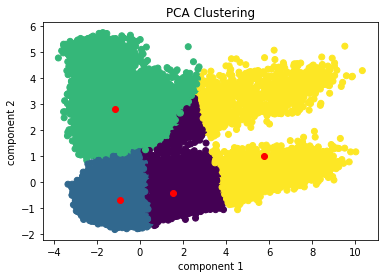

In [88]:
plt.title('PCA Clustering')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.scatter(X[:,0], X[:,1], c=clusters) # auto assign colors to label to differentiate
plt.scatter(centers[:,0], centers[:,1], c='red')
plt.show()


f = pcachart.get_figure()
f.savefig("pcaclusterchart.jpg")

In [31]:
# refactor later if have time
# from sklearn.pipeline import make_pipeline
# pipeline = make_pipeline(
#     StandardScaler(),
#     NearestNeighbors())

# pipeline.fit(X)

# UNIFINISHED Auto Encoder -> NN

In [32]:
# from keras.models import Model

In [33]:
# encoding_dim = 10 # compression of factor 4.1 assuming input of 41

# Export Model with Joblib

In [34]:
filename = 'NearestNeighborGenres.sav'

In [35]:
joblib.dump(neigh, filename)

['NearestNeighborGenres.sav']

In [36]:
pca_filename = 'PCANearestNeighborGenres.sav'
joblib.dump(pca_neigh, pca_filename)

['PCANearestNeighborGenres.sav']

In [37]:
# one hot encoding, rolled back
# def encode_and_bind(original_dataframe, feature_to_encode):
#     dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#     res = pd.concat([original_dataframe, dummies], axis=1)
#     return(res)

# df = encode_and_bind(df, 'key')
# df = encode_and_bind(df, 'mode')
# df = encode_and_bind(df, 'time_signature')

# Export Model with Pickle

In [38]:
import pickle

model = neigh

filename = 'filename.pkl'

with open(filename, 'wb') as f:
    pickle.dump(model, f)
#then send this pkl file to DE team

#DE team:
#Make sure to save the pkl file in the same folder as the app

#To read it into the app:

# with open(filename, 'rb') as f:
#     model = pickle.load(f)